In [1]:
import torch
import random
from d2l import torch as d2l

In [2]:
"""⽣成y=Xw+b+噪声"""
def synthetic_data(w,b,num_examples):
    # 随机生成标准差为0，均值为1，形状为(num_examples,len((w)）的正态分布数据，因为w是x（特征，x1，x2。。。）的系数，即它的长度一定和特征的长度一样
    x=torch.normal(0,1,(num_examples,len((w))))
    # torch.matmul(x,w) 计算两个张量的矩阵乘积
    y=torch.matmul(x,w)+b
    #添加噪声，提高模型的泛化能力
    y+=torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))


In [3]:
true_w=torch.tensor([2,-3.4])#给出特征的系数值，这两个系数 说明是两个特征
true_b=4.2#截距为b
features,labels=synthetic_data(true_w,true_b,1000)
print('features:',features[0],'\nlabel:',labels[0])
#打印出来的其实是第0行数据的特征，x1,x2,和它对应的标签 label

features: tensor([-0.4217, -0.9197]) 
label: tensor([6.4761])


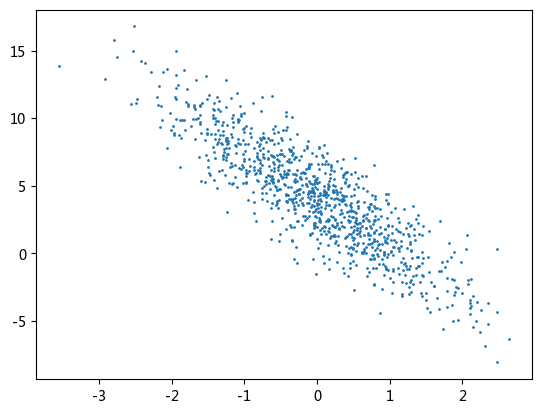

In [4]:
#通过散点图观测第二个特征值x2和label的线性关系
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
# 使用 detach() 可以将其从计算图中分离出来，变成普通的张量，不再与计算图相关联，避免出现不必要的计算。
# numpy() 方法可以将 PyTorch 张量转换为 NumPy 数组，这样可以方便地使用 NumPy 库中的函数进行数据分析和可视化等操作

In [5]:
#用于生成一个可迭代的数据集  接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。每个小批量包含一组特征和标签
def data_iter(batch_size,features,labels):
    #计算样本数量
    num_examples=len(features)
    #样本下标列表
    indices=list(range(num_examples))
    #随机打乱列表
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        #关键字yield定义生成器函数，可以像迭代器一样逐个返回值，而不是一次性返回全部值  知道循环完毕或者遇到return语句结束
        yield features[batch_indices],labels[batch_indices]



In [6]:
batch_size=10
for x ,y in data_iter(batch_size,features,labels):
    print(x,'\n',y)
    break
#利用gpu并行运算优势，每个样本和对应的损失函数的梯度都可以被并行运算，且gpu在处理几百个样本时，花费的时间不会比处理一个样本多太多
#一般不用上诉函数方法，一般使用深度学习内置的迭代器

tensor([[-0.4780,  0.8706],
        [ 1.4682, -0.0145],
        [ 0.1872, -0.8329],
        [-1.1881, -0.5491],
        [-1.2945,  1.0058],
        [-1.3350, -0.5321],
        [ 0.0338,  0.0087],
        [-0.5704,  0.1711],
        [-0.3679, -1.8904],
        [-1.2193, -1.5055]]) 
 tensor([[ 0.2715],
        [ 7.1898],
        [ 7.4052],
        [ 3.6933],
        [-1.8154],
        [ 3.3463],
        [ 4.2464],
        [ 2.4728],
        [ 9.8801],
        [ 6.8799]])


In [7]:
#初始化模型参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

#定义模型
def line_reg(x,w,b):
    return torch.matmul(x,w)+b
#定义损失函数(这里使用的均方误差)
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2
#定义优化算法

# 在Python中，函数内的可变对象（如列表、字典、张量等）可以被原处修改。
# 因此，即使我们没有显式地返回w和b，当param是指向w和b的引用时，w和b也会在param被原处修改的过程中更新。
# 这里的w和b是在循环体外部定义的全局变量，因此在循环体内部修改它们的值时，循环体外部的w和b变量的值也会被更新。注意：在Python中，整数是不可变类型
def sgd(params,lr,batch_size):
    #这里我们使用torch.no_grad()函数临时禁用pytorch自带的自动微分功能，改为自动手动更新模型参数，减少内存的使用和提高计算速度
    with torch.no_grad():
        for param in params:
            # param.grad/batch_size得到规范化后的梯度值 ，lr*param.grad/batch_size梯度按学习率的变化值，param-=lr*param.grad/batch_size更新后的梯度值
            param-=lr*param.grad/batch_size
            #清楚本轮的梯度，以便下一轮训练不会受本轮的梯度影响
            param.grad.zero_()
#
lr=0.03
num_epochs=3
net=line_reg
loss=squared_loss

for epoch in range(num_epochs):
    #对这一批次的每个batch_size大小样本进行梯度更新
    for x,y in data_iter(batch_size,features,labels):
        l=loss(net(x,w,b),y)
        # 在 PyTorch 中，反向传播算法要求损失函数是一个标量（scalar），因为只有标量才有一个唯一的梯度值。
        # 如果损失函数是一个非标量（如矩阵或张量），那么我们需要先将它转化为一个标量，才能进行反向传播
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    #对每个批次的样本进行梯度更新
    with torch.no_grad():#避免受前一次批次的梯度影响
        train_l=loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')


epoch1,loss0.044728
epoch2,loss0.000197
epoch3,loss0.000050


In [8]:
print(f'w的估计误差{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差{true_b-b}')

w的估计误差tensor([ 0.0008, -0.0008], grad_fn=<SubBackward0>)
b的估计误差tensor([0.0002], grad_fn=<RsubBackward1>)


In [51]:
#c=5 python中整数是不可变类型这样传入是不可改的 或者改成c=[5]
#d=6
c = torch.tensor([5])
d = torch.tensor([6])
li=[c,d]
def bb(li_1):
    for i in li_1:
        i=i+2#如果改的c[0]=5,这里就要用i[0]-=2,还有+=，-=等这类运算符不会开辟新空间是原地赋值，而i=i+2,此时就开辟了新空间，无法改变函数外的值
    print(li_1)
bb(li)
print(li)


[tensor([5]), tensor([6])]
[tensor([5]), tensor([6])]
